In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_tuned_Loc5')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,vx,vy,vz
5800,-156.663834,190.756733,0.058864,0.216966,-0.967159,-0.132394
5305,-150.761216,183.347261,-0.043687,-0.074117,-0.991439,-0.107494
593,-150.403880,188.252553,-0.347951,-0.591821,-0.751045,-0.292711
5257,-146.829250,179.169166,-0.076148,0.088374,-0.991636,-0.094068
1117,-145.124170,195.795708,-0.152879,-0.161285,-0.944600,-0.285863
...,...,...,...,...,...,...
34,136.914160,174.899237,0.188002,0.188184,0.971356,-0.145099
3599,141.933148,189.717501,-0.377533,-0.597011,0.708085,-0.377086
1900,143.942632,193.243665,0.238725,-0.042108,0.967190,-0.250540
3546,145.390511,188.388047,-0.015920,-0.030631,0.990473,-0.134256


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))
#     labels = labels[df_la_idx,:]
#     summ_stats = summ_stats[df_la_idx,:]
#     with pd.option_context('display.max_rows',10):
#         display(df_la.loc[df_la_idx])

print(json.dumps(ranges))

0.07% outside bounds.
{"x": [-50, 50], "y": [-1400, 1400], "z": [20.0, 200.0], "alpha": [0, 3.141592653589793], "h": [-1.0, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [20.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "r_s": [5.0, 12.0], "l_t": [20.0, 800.0], "r_t": [0.2, 0.8], "r_d": [0.1, 0.5], "r_tu": [0.05, 0.4], "l_d": [100.0, 300.0], "r_a": [0.1, 0.5], "r_o": [0.1, 0.5], "l_o": [10.0, 150], "vx": [-1.0, 1.0], "vy": [-1.0, 1.0], "vz": [-1.0, 1.0], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,vx,vy,vz
0,0.356914,-0.545328,0.037867,-0.272156,0.049510,0.960979
1,0.501986,-0.366483,0.533298,0.629934,-0.769769,-0.103146
2,0.358780,0.594731,-0.118573,-0.514561,0.352022,0.781862
3,0.060765,0.352509,-0.009053,-0.106477,-0.911809,0.396570
4,-0.204442,-0.217781,-0.441136,0.246489,-0.225782,-0.942479
...,...,...,...,...,...,...
5940,-0.145309,-0.160493,-0.834186,-0.792955,0.579722,0.187468
5941,0.124079,-0.212319,0.047885,-0.647047,0.199646,-0.735848
5942,-0.046339,-0.082288,0.185007,0.939159,-0.333391,-0.082652
5943,-0.104197,0.841172,-0.103618,-0.260024,-0.091388,-0.961268


## Build model

In [7]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = False
model_name = 'FCN_batch256'
if direction_vec:
    model_name += '_dv'
model_name += '.pth'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

## Train model

In [8]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)

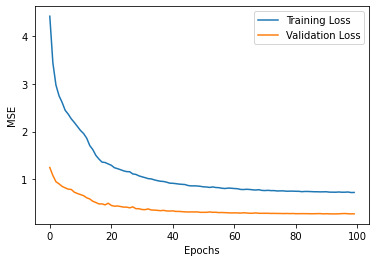

In [9]:
isTrain = False
if not isTrain:
    LOSS_PATH = 'cell_inference/resources/results/pytorch_losses'
    loss_file = '17_59_04__08_09_2022.csv' # select data
    history = pd.read_csv(os.path.join(LOSS_PATH, loss_file)).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

In [10]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

### Perform on stylized model

In [11]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:,i] = org_scale(y[:,i], ranges[lb])
    output[:,i] = org_scale(output[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(y[:,i], output[:,i])))

R2 Score y-shift:   0.732
R2 Score d:         0.888
R2 Score theta:     0.624
R2 Score vx:        0.811
R2 Score vy / h:    0.934
R2 Score vz:        0.802
R2 Score phi:       0.639


Stylized Cell Testing Data: Ground Truth VS Predicted


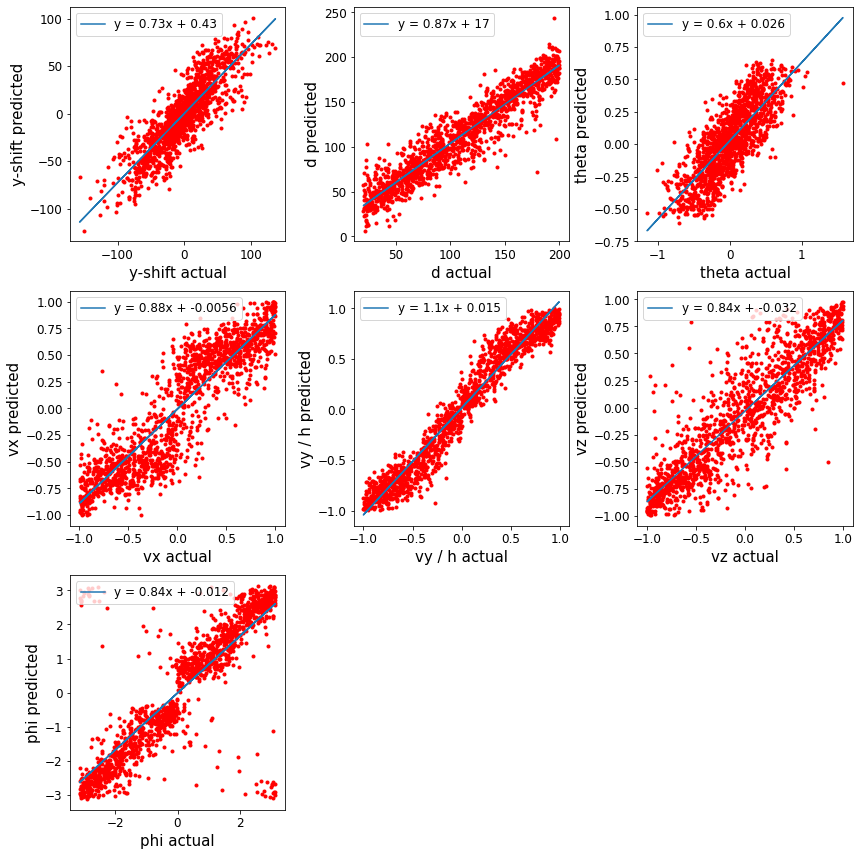

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:,i], output[:,i], c='red', marker='.')
    m, b = np.polyfit(y[:,i], output[:,i], 1)
    ax.plot(y[:,i], m * y[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

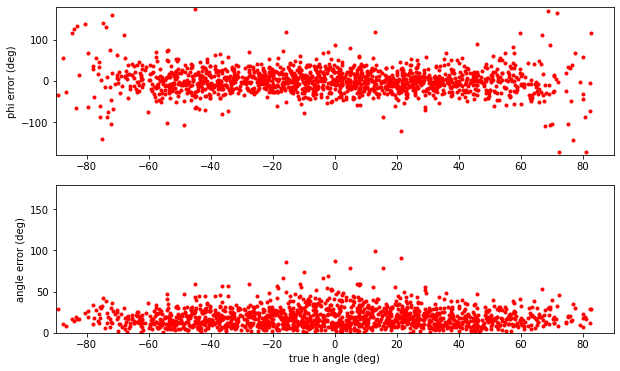

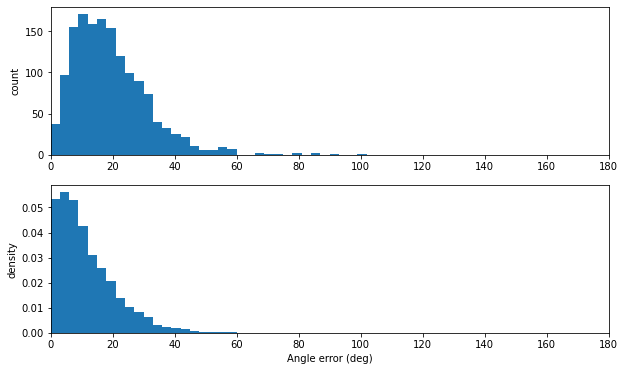

RMSE of angle: 22.9


In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 60
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Random cases)

In [14]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics

#### Ground truth

In [15]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if direction_vec:
    dv = hphi2unitsphere(labels_true[:, orient_idx0])
    labels_true = np.hstack([np.delete(labels_true, orient_idx0, axis=1), dv, labels_true[:, [orient_idx0[1]]]])
if has_yshift:
    labels_true[:, ys_idx] = STATS['ys']

#### Prediction

In [16]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(label_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    labels_pred[:, orient_idx1] = trivarnorm2unitsphere(labels_pred[:, orient_idx1])
    labels_pred = np.hstack([labels_pred, unitsphere2hphi(labels_pred[:, orient_idx1])[:, [1]]])

for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(labels_true[:,i], labels_pred[:,i])))

R2 Score y-shift:   -0.055
R2 Score d:         0.225
R2 Score theta:     0.518
R2 Score vx:        0.637
R2 Score vy / h:    0.721
R2 Score vz:        0.036
R2 Score phi:       0.277


Detailed Cell Testing Data: Ground Truth VS Predicted


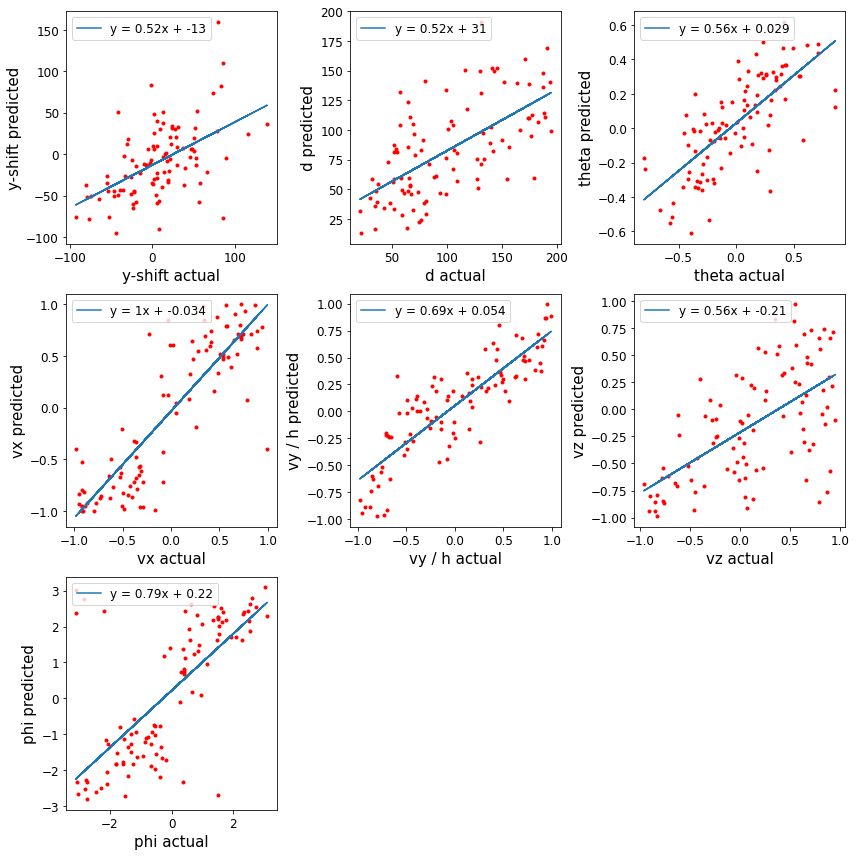

In [17]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:,i], labels_pred[:,i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:,i], labels_pred[:,i], 1)
    ax.plot(labels_true[:,i], m * labels_true[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

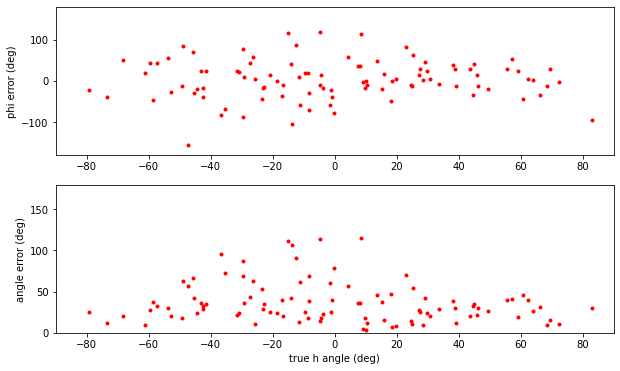

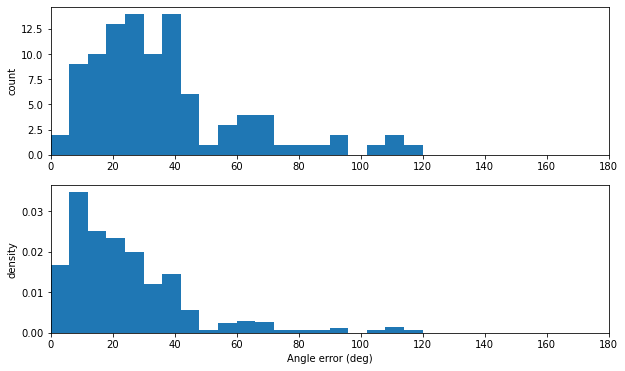

RMSE of angle: 44.4


In [18]:
if check_orient:
    bins = 30
    angle = np.arccos(cosine_similarity(labels_true[:, orient_idx2], labels_pred[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (labels_pred[:, orient_idx2[1]] - labels_true[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Selected cases)

In [19]:
# import os

# DATA_PATH = 'cell_inference/resources/detailed'  # '/home/matt/data/InVivoLFPs/detailed_cell_simulation/without_basal_dendrite'
# COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

# # model_name = 'neuronal_model_496930324'
# model_name = 'neuronal_model_491766131'
# detailed_cells = [
#     os.path.join(DATA_PATH, model_name+'_h0.0.h5'),
#     os.path.join(DATA_PATH, model_name+'_h0.7071.h5'),
#     os.path.join(DATA_PATH, model_name+'_h1.0.h5')
# ]

#### Ground truth

In [20]:
# from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol

# loc_param = [0., 350., 80., np.pi/4, 1.0, 0.]
# loc_params = np.tile(loc_param,(len(detailed_cells),1)) 
# loc_params[:,4] = [0.0, 0.7071, 1.0]

# labels_true = loc_params[:,[1,0,2,4,5]]
# labels_true[:,1], labels_true[:,2] = cart2pol(labels_true[:,1], labels_true[:,2])

In [21]:
# import h5py
# from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, get_y_window, calculate_stats
# from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

# pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
# lfp_list = []
# tt = []

# summ_stats_test = []
# bad_indices = []
# yshift = []

# amp_scale = 1.
# for i, sample in enumerate(detailed_cells):
#     with h5py.File(sample, "r") as f:
#         lfp = f['data'][:].reshape((-1, 384)) * amp_scale
#         dt = f.attrs['dt']

#     start, end = get_spike_window(lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
#     lfp_list.append(lfp[start:end,:])
#     tt.append(np.arange(lfp.shape[0])[start:end] * dt)
    
#     try:
#         g_lfp, _, y_c = build_lfp_grid(lfp_list[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
#     except ValueError:
#         bad_indices.append(i)
#         continue
#     summ_stats_test.append(calculate_stats(g_lfp))
#     if has_yshift:
#         yshift.append(y_c - labels_true[i, ys_idx])

# summ_stats_test = np.array(summ_stats_test)
# labels_true = np.delete(labels_true, bad_indices, axis=0)
# if has_yshift:
#     labels_true[:, ys_idx] = np.array(yshift)
# print('%d bad samples.' % len(bad_indices))

# df_la_true = pd.DataFrame(labels_true, columns=inference_list)

#### Prediction

In [22]:
# device = torch.device("cpu")
# model.eval()

# labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# # back to original scale
# for i, lb in enumerate(inference_list):
#     labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

# df_la_pred = pd.DataFrame(labels_pred, columns=inference_list)

In [23]:
# df_comp = {}
# for c1, c2 in zip(df_la_true.columns, df_la_pred.columns):
#     df_comp[c1+' true'] = df_la_true[c1]
#     df_comp[c1+' pred'] = df_la_pred[c2]
# df_comp = pd.DataFrame(df_comp)

# # rad to degree
# rad2deg = lambda x: 180 / np.pi * x

# for p in ['theta', 'h', 'phi']:
#     idx = df_comp.columns.get_loc(p + ' pred') + 1
#     for d in [' pred', ' true']:
#         val = df_comp[p + d]
#         if p == 'h':
#             val = np.pi/2 - np.arccos(val)
#         df_comp.insert(idx, p + d + ' (degree)', rad2deg(val))

# with pd.option_context('display.float_format', '{:.4g}'.format, 'max_columns', None):
#     display(df_comp)